# Animal Faces Classification

In [46]:
# !kaggle datasets download -d andrewmvd/animal-faces
# !unzip animal-faces.zip

## Import Libs

In [47]:
import torch
from torch import nn # for building the models arch. 
from torch.optim import Adam # optimizer for training the model
import torchvision.transforms as transforms # for the data augmentation and preprocessing
from torch.utils.data import Dataset, DataLoader # for creating custom datasets and loading data in batches
from sklearn.preprocessing import LabelEncoder # for encoding the labels of the dataset
from PIL import Image # for image processing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device: ", device)

Device:  cpu


## Reading Images

## 

In [48]:
image_path = []
labels = []

# Reading each image and its corresponding label from the dataset
for i in os.listdir("data/animal-faces"):
    # print("\nProcessing folder: ", i)
    for label in os.listdir(f"data/animal-faces/{i}"):
        # print("Label: ", label)
        for image in os.listdir(f"data/animal-faces/{i}/{label}"):
            # print("Image: ", image)
            image_path.append(f"data/animal-faces/{i}/{label}/{image}")
            labels.append(label)

# Creating dataframe to store the image paths and their corresponding labels
df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])

print(df["labels"].unique())
print(df.head())
print(df.tail())

<StringArray>
['cat', 'dog', 'wild']
Length: 3, dtype: str
                                          image_path labels
0  data/animal-faces/train/cat/pixabay_cat_000455...    cat
1  data/animal-faces/train/cat/pixabay_cat_001993...    cat
2  data/animal-faces/train/cat/pixabay_cat_004633...    cat
3  data/animal-faces/train/cat/pixabay_cat_002242...    cat
4  data/animal-faces/train/cat/pixabay_cat_002524...    cat
                                              image_path labels
16125  data/animal-faces/val/wild/flickr_wild_003335.jpg   wild
16126  data/animal-faces/val/wild/flickr_wild_002942.jpg   wild
16127  data/animal-faces/val/wild/flickr_wild_000833.jpg   wild
16128  data/animal-faces/val/wild/flickr_wild_002956.jpg   wild
16129  data/animal-faces/val/wild/flickr_wild_003137.jpg   wild


## Preprocessing

In [49]:
train = df.sample(frac=0.7) # 70% of the data for training
test = df.drop(train.index) # remaining 30% for testing
val = test.sample(frac=0.5) # 15% of the data of test for validation
test = test.drop(val.index) # Remaining 15% for testing

print("Train set size: ", len(train))
print("Test set size: ", len(test))
print("Validation set size: ", len(val))

# Label encoding the labels of the dataset
label_encoder = LabelEncoder()
label_encoder.fit(df["labels"]) # fitting the label encoder on the labels of the dataset

# Makes all the images have the same properties (size, normalization, etc.) before feeding them into the model.
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32)
])


Train set size:  11291
Test set size:  2419
Validation set size:  2420


## Custom Image Dataset

In [ ]:
class AnimalFaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.labels = torch.tensor(label_encoder.transform(df['labels']).astype(int), dtype=torch.long) # encoding the labels of the dataset from string to integer
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx,0] # getting the image path from the dataframe
        labels = self.labels[idx] # getting the label from the encoded labels (integers)
        
        image = Image.open(img_path).convert("RGB") # opening the image and converting it to RGB
        
        if self.transform:
            image = self.transform(image) # applying the transformations to the image
            
        return image, labels

In [51]:
train_dataset = AnimalFaceDataset(df = train, transform=transform)
valid_dataset = AnimalFaceDataset(df = val, transform=transform)
test_dataset = AnimalFaceDataset(df=test, transform=transform)

## Display Random Image

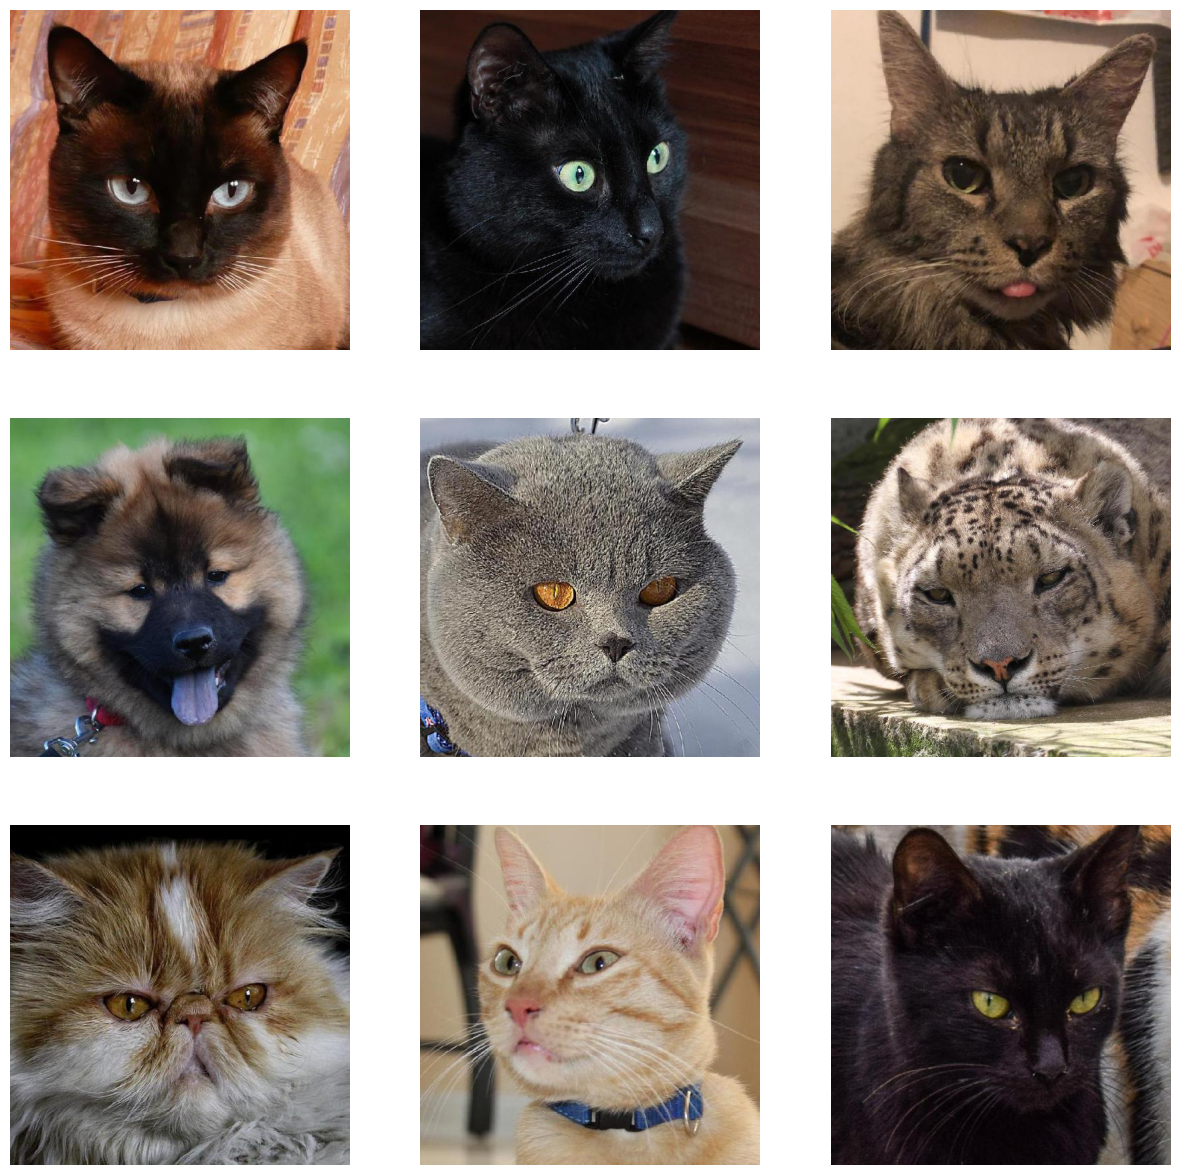

In [52]:
n_row = 3
n_col = 3

fig, ax = plt.subplots(n_row, n_col, figsize = (15,15))

# Display random images from df. We will be converting the int to RGB
for row in range(n_row):
    for col in range(n_col):
        image = Image.open(df.sample(n=1).iloc[0]["image_path"]).convert("RGB")
        
        ax[row, col].imshow(image)
        ax[row,col].axis("off")

plt.show()

## Feature Engineering

In [59]:
LR = 1e-4
BATCH_SIZE = 16
EPOCHS = 10

# Creating Data Loaders for training, validation, and testing
train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

TypeError: object of type 'AnimalFaceDataset' has no len()